In [30]:
# import required classes
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time
import random

In [31]:
# define paths
# data_files = os.path.join(os.getcwd(), r'data\images\all')
data_files = os.path.join(os.getcwd(), r'data\images\queries')
features_dir = os.path.join(data_files, 'features')
if not os.path.exists(features_dir): 
    os.makedirs(features_dir)
    print ("Create feature folder %s" % features_dir)

# define model
# Use VGG-16 as the architecture and ImageNet for the weight
base_model = VGG16(weights='imagenet')
# feature = VGGFace(model='resnet50')
# Customize the model to return features from fully-connected layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [32]:
# define extract image function that extract the features of the image according to the given model
def extract(img, model):
    """
    @param: Pillow.image
    @param: Keras.model.Model
    @return normalzied vector of features
    It resize the image to (224,224) and convert to 'rgb' then call the input model to extract features
    """
    
    img = img.resize((224, 224))
    img = img.convert('RGB') # Convert the image color space
    x = image.img_to_array(img) # Reformat the image
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)[0] # Extract Features
    return feature / np.linalg.norm(feature)

In [33]:
# get the images and generate the feature extraction of them
before = time.time()
ext = ['png', 'jpg', 'gif']
files = []
[files.extend(glob.glob(os.path.join(data_files, '*.'+e))) for e in ext]

for img_path in files:
    img_feature_file = '%s.npy' % (os.path.splitext(os.path.basename(img_path))[0],)
    img_feature_file_path = os.path.join(features_dir, img_feature_file)
    if not os.path.exists(img_feature_file_path):
        feature = extract(Image.open(img_path), model)
        np.save(img_feature_file_path, feature)

In [34]:
print("Features generated/updated for %s files in %0.2fs" % (len(files), time.time()-before))

before = time.time()

#loading features
lst_features = []
lst_imgs = []
for f_path in glob.glob(os.path.join(features_dir, '*')):
    lst_features.append(np.load(f_path))
    img_path = os.path.join(data_files, '%s.%s' % (os.path.splitext(os.path.basename(f_path))[0], 'jpg'))
    
    if not os.path.exists(img_feature_file_path):
        img_path = os.path.join(data_files, '%s.%s' % (os.path.splitext(os.path.basename(f_path))[0], 'png'))
    
    if os.path.exists(img_feature_file_path):
        lst_imgs.append(img_path)
    
print("Loaded matrix of features for %s files in %0.2fs" % (len(lst_features), time.time()-before, ))

before = time.time()
features = np.vstack(lst_features)
print("Loaded matrix of features with dimensions: %s in %0.2fs" % (features.shape, time.time()-before, ))

before = time.time()
query_img = Image.open(os.path.join(data_files, '1392044131330019334_3-18679.jpg'))
query_features = extract(query_img, model) #extract features for image
dists = np.linalg.norm(features - query_features, axis=1) #distance to all images

Features generated/updated for 7 files in 0.95s
Loaded matrix of features for 7 files in 0.00s
Loaded matrix of features with dimensions: (7, 4096) in 0.00s


Features processing for 7 files takes 62.74s


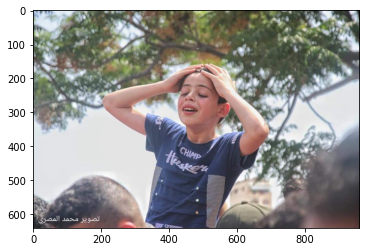

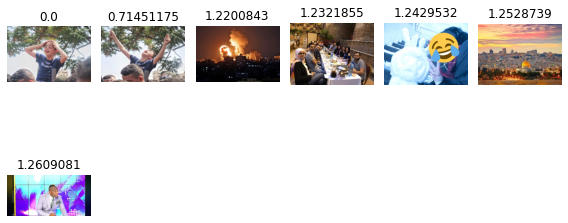

In [37]:
#sort and pick up top 6 and get img path near score
img_ids = np.argsort(dists)[:4*6]
scores = [(dists[id], lst_imgs[id]) for id in img_ids]

#print('Looking for below image out of %s' % (len(q_img_paths,)))
plt.imshow(query_img)

axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(4*6):
    if a < len(scores):
        score = scores[a]
        axes.append(fig.add_subplot(4, 6, a+1))
        subplot_title=str(score[0])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open(score[1]))
fig.tight_layout()

print("Features processing for %s files takes %0.2fs" % (len(files), time.time()-before))

plt.show()